In [124]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os
from sklearn.linear_model import LinearRegression
from pathlib import Path
from datetime import datetime

In [125]:
def read_SMARD_Generation_data(path):
    df = pd.read_csv(path,delimiter= ';', thousands='.', decimal=',', dayfirst ="True") #, parse_dates=[[0,1]]

    #Herauslöschen der Spalte Datum bis, da diese keine zusätzlichen Informationen bietet
    df.drop(columns=["Datum bis"], inplace=True)

    
    
    #Umbenennung der Spalten
    df.rename(columns={
        "Datum von":"Datum",
        "Biomasse [MWh] Originalauflösungen":"Biomasse",
        "Wasserkraft [MWh] Originalauflösungen":"Wasserkraft",
        "Wind Offshore [MWh] Originalauflösungen":"Wind Offshore",
        "Wind Onshore [MWh] Originalauflösungen":"Wind Onshore",
        "Photovoltaik [MWh] Originalauflösungen":"Photovoltaik",
        "Sonstige Erneuerbare [MWh] Originalauflösungen":"Sonstige Erneuerbare",
        "Kernenergie [MWh] Originalauflösungen":"Kernenergie",
        "Braunkohle [MWh] Originalauflösungen":"Braunkohle",
        "Steinkohle [MWh] Originalauflösungen":"Steinkohle",
        "Erdgas [MWh] Originalauflösungen":"Erdgas",
        "Pumpspeicher [MWh] Originalauflösungen":"Pumpspeicher",
        "Sonstige Konventionelle [MWh] Originalauflösungen":"Sonstige Konventionelle"    
    }, inplace = True)

    df.drop(columns = ["Biomasse"], inplace = True)
    df.drop(columns = ["Wasserkraft"], inplace = True)
    df.drop(columns = ["Sonstige Erneuerbare"], inplace = True)
    df.drop(columns = ["Kernenergie"], inplace = True)
    df.drop(columns = ["Braunkohle"], inplace = True)
    df.drop(columns = ["Steinkohle"], inplace = True)
    df.drop(columns = ["Erdgas"], inplace = True)
    df.drop(columns = ["Pumpspeicher"], inplace = True)
    df.drop(columns = ["Sonstige Konventionelle"], inplace = True)


    #Formatierung der Datumstpalte
    df['Datum'] = pd.to_datetime(df['Datum'], format= '%d.%m.%Y %H:%M')
    #addTimeInformation(df)

    df = df[~((df['Datum'].dt.month == 2) & (df['Datum'].dt.day == 29))].sort_values(by="Datum")
    df.index =range(len(df))


    return df


def read_SMARD_Installed_data(path):
    df = pd.read_csv(path,delimiter= ';', thousands='.', decimal=',', dayfirst ="True") #, parse_dates=[[0,1]]

    #Herauslöschen der Spalte Datum bis, da diese keine zusätzlichen Informationen bietet
    df.drop(columns=["Datum bis"], inplace=True)

    
    
    #Umbenennung der Spalten
    df.rename(columns={
        "Datum von":"Datum",
        "Biomasse [MW] Originalauflösungen":"Biomasse",
        "Wasserkraft [MW] Originalauflösungen":"Wasserkraft",
        "Wind Offshore [MW] Originalauflösungen":"Wind Offshore",
        "Wind Onshore [MW] Originalauflösungen":"Wind Onshore",
        "Photovoltaik [MW] Originalauflösungen":"Photovoltaik",
        "Sonstige Erneuerbare [MW] Originalauflösungen":"Sonstige Erneuerbare",
        "Kernenergie [MW] Originalauflösungen":"Kernenergie",
        "Braunkohle [MW] Originalauflösungen":"Braunkohle",
        "Steinkohle [MW] Originalauflösungen":"Steinkohle",
        "Erdgas [MW] Originalauflösungen":"Erdgas",
        "Pumpspeicher [MW] Originalauflösungen":"Pumpspeicher",
        "Sonstige Konventionelle [MW] Originalauflösungen":"Sonstige Konventionelle"    
    }, inplace = True)

    #Herauslöschen der Spalten, die nicht benötigt werden
    df.drop(columns = ["Datum"], inplace = True) #Datum wird nicht benötigt, da später das Datum von der Generation übernommen wird
    df.drop(columns = ["Biomasse"], inplace = True)
    df.drop(columns = ["Wasserkraft"], inplace = True)
    df.drop(columns = ["Sonstige Erneuerbare"], inplace = True)
    df.drop(columns = ["Kernenergie"], inplace = True)
    df.drop(columns = ["Braunkohle"], inplace = True)
    df.drop(columns = ["Steinkohle"], inplace = True)
    df.drop(columns = ["Erdgas"], inplace = True)
    df.drop(columns = ["Pumpspeicher"], inplace = True)
    df.drop(columns = ["Sonstige Konventionelle"], inplace = True)

    
    return df

In [126]:
def getData(data_path, datatype):
    dataFrames = {} # Dictionary für die df für jedes Jahr
    path_var = "SMARD-Datein\\" #Pfad auf den Ordner, um später durch die Datein zu navigieren
    #project_root = Path(__file__).resolve().parent.parent
    #csv_folder = project_root/ "CSV"

    #Schleife für die Jahre 2015-2023 und Einlesen der Datei
    for year in range(2015,2024): # hier könnte man später sich die Jahre auch vom User geben lassen, welche Jahre er gerne eingelesen haben möchte
        #Dateipfad für das entsprechende Jahr
        file_path = os.path.join(path_var,data_path.format(year = year, next_year = year +1))
        
        if os.path.exists(file_path):   #Falls dieser zusammengesetze Pfad existiert,...
            if datatype == "Generation": # und der Datentyp Generation ist,...
                dataFrames[year] = read_SMARD_Generation_data(file_path)
            elif datatype == "Installed": # und der Datentyp Installed ist,...
                dataFrames[year] = read_SMARD_Installed_data(file_path)   #... soll dieser eingelesen werden
            print(f"Data for {year} loaded succsessfully.")
        else:
            print(f"File for {year} not found at path: {file_path}") #... anstonsten nicht
        #anzahl_zeilen = dataFrames[year].shape[0]
        #print(f"Anzahl Zeilen {year}: {anzahl_zeilen}")

    
    return dataFrames   #Rückgabe der eingelesenen Daten als DataFrame gespeichert in einem Dictionary

In [127]:
def performance_factors(directoryGeneration,directoryInstalled):
    directory_performance_factors = {}
    # Ensure the directory exists

    for year in range(2015,2024):
        #Faktoren für die Performance errechnen
        PV_factor = directoryInstalled[year]["Photovoltaik"].iloc[0]*0.25
        OnShore_factor = directoryInstalled[year]["Wind Onshore"].iloc[0] * 0.25
        OffShore_factor = directoryInstalled[year]["Wind Offshore"].iloc[0] * 0.25

        #Anlegung eines leeren DataFrames für die Performance Faktoren pro Viertelstunde
        performance_factors = pd.DataFrame(columns=["Datum","Photovoltaik", "Wind Onshore", "Wind Offshore"])

        #Befüllen des DataFrames mit den errechneten Performance
        performance_factors["Datum"] = directoryGeneration[year]["Datum"]  
        performance_factors["Photovoltaik"] = directoryGeneration[year]["Photovoltaik"] / PV_factor
        performance_factors["Wind Onshore"] = directoryGeneration[year]["Wind Onshore"] / OnShore_factor
        performance_factors["Wind Offshore"] = directoryGeneration[year]["Wind Offshore"] / OffShore_factor

        #Hinzufügen des DataFrames für das entsprechende Jahr zum Directory
        directory_performance_factors[year] = performance_factors


        
        directory_performance_factors[year].to_csv(f"Performance_Factors_{year}.csv", index = False)

    return directory_performance_factors


       

In [ ]:
def determinePerformanceSzenarios(directory_performance):   #Funktion zur Ermittlung der verschiedenen Szenarien
    directory_szenarios = {}    #Dictionary für die verschiedenen Szenarien (Dort sind die DataFrames für die Szenarien hinterlegt)
    meanPerformanceFactors=pd.DataFrame(columns=["Jahr","Photovoltaik","Wind Onshore","Wind Offshore"]) #Leeres DataFrame für die mittleren Performance Faktoren
    #Schleife für die Jahre 2015-2023, die die mittleren Performance Faktoren für die Szenarien berechnet
    for year in range(2015,2024):
        meanPV=directory_performance[year]["Photovoltaik"].mean()
        meanOnshore=directory_performance[year]["Wind Onshore"].mean()
        meanOffshore=directory_performance[year]["Wind Offshore"].mean()
        meanPerformanceFactors = pd.concat([meanPerformanceFactors, pd.DataFrame([{"Jahr": year, "Photovoltaik": meanPV, "Wind Onshore": meanOnshore, "Wind Offshore": meanOffshore}])], ignore_index=True)

    #Ermittlung des besten, schlechtesten Jahr pro Technologie
    bestPV = meanPerformanceFactors.loc[meanPerformanceFactors["Photovoltaik"].idxmax()]
    worstPV = meanPerformanceFactors.loc[meanPerformanceFactors["Photovoltaik"].idxmin()]

    bestOnshore = meanPerformanceFactors.loc[meanPerformanceFactors["Wind Onshore"].idxmax()]
    worstOnshore = meanPerformanceFactors.loc[meanPerformanceFactors["Wind Onshore"].idxmin()]

    bestOffshore = meanPerformanceFactors.loc[meanPerformanceFactors["Wind Offshore"].idxmax()]
    worstOffshore = meanPerformanceFactors.loc[meanPerformanceFactors["Wind Offshore"].idxmin()]

    bestCase = pd.concat([directory_performance[bestPV["Jahr"]]["Photovoltaik"], directory_performance[bestOnshore["Jahr"]]["Wind Onshore"], directory_performance[bestOffshore["Jahr"]]["Wind Offshore"]], axis=1)
    worstCase = pd.concat([directory_performance[worstPV["Jahr"]]["Photovoltaik"], directory_performance[worstOnshore["Jahr"]]["Wind Onshore"], directory_performance[worstOffshore["Jahr"]]["Wind Offshore"]], axis=1)

    #Ermittlung eines durchschnittlichen Jahres über die letzten 8 Jahre
    meanOveralldf = pd.DataFrame(columns=["Photovoltaik","Wind Onshore","Wind Offshore"])    #Leeres DataFrame für den durchschnittlichen Jahresverlauf
    averagePV = pd.DataFrame()    #Leeres DataFrame für den durchschnittlichen Jahresverlauf
    averageOnshore = pd.DataFrame()  #Leeres DataFrame für den durchschnittlichen Jahresverlauf
    averageOffshore = pd.DataFrame()    #Leeres DataFrame für den durchschnittlichen Jahresverlauf
    num_years = len(directory_performance)  #Anzahl der Jahre, die in dem Dictonary "directory_performance" hinterlegt sind

    #Iteration über jedes Jahr im Directory
    for year, df in directory_performance.items():

        
        averagePV = averagePV.add(df[["Photovoltaik"]],fill_value=0)
        averageOnshore = averageOnshore.add(df[["Wind Onshore"]],fill_value=0)
        averageOffshore = averageOffshore.add(df[["Wind Offshore"]],fill_value=0)

       
    
    #average(-Pv,-Onshore,-Offshore) /= num_years #Berechnung des Durchschnitts
    averagePV /= num_years
    averageOnshore /= num_years
    averageOffshore /= num_years

    #zusammenführung der durchschnittlichen Performance Faktoren
    meanOveralldf = pd.concat([averagePV, averageOnshore, averageOffshore], axis=1)


    directory_szenarios["BestCase"] = bestCase
    directory_szenarios["WorstCase"] = worstCase
    directory_szenarios["AverageCase"] = meanOveralldf
    
    return directory_szenarios
    

In [134]:
data_path_generation = "Realisierte_Erzeugung_{year}01010000_{next_year}01010000_Viertelstunde.csv"
data_path_installed = "Installierte_Erzeugungsleistung_{year}01010000_{next_year}01010000_Jahr.csv"
#directory_yearly_generation = getData(data_path_generation)
directory_yearly_installed = getData(data_path_installed, "Installed")
directory_yearly_generation = getData(data_path_generation, "Generation")

directory_performance_factors = performance_factors(directory_yearly_generation,directory_yearly_installed)
directory_Szenario = determinePerformanceSzenarios(directory_performance_factors)
directory_Szenario["WorstCase"].to_csv("WorstCase.csv")


Data for 2015 loaded succsessfully.
Data for 2016 loaded succsessfully.
Data for 2017 loaded succsessfully.
Data for 2018 loaded succsessfully.
Data for 2019 loaded succsessfully.
Data for 2020 loaded succsessfully.
Data for 2021 loaded succsessfully.
Data for 2022 loaded succsessfully.
Data for 2023 loaded succsessfully.
Data for 2015 loaded succsessfully.
Data for 2016 loaded succsessfully.
Data for 2017 loaded succsessfully.
Data for 2018 loaded succsessfully.
Data for 2019 loaded succsessfully.
Data for 2020 loaded succsessfully.
Data for 2021 loaded succsessfully.
Data for 2022 loaded succsessfully.
Data for 2023 loaded succsessfully.


C:\Users\aaron\AppData\Local\Temp\ipykernel_2684\633103039.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  meanPerformanceFactors = pd.concat([meanPerformanceFactors, pd.DataFrame([{"Jahr": year, "Photovoltaik": meanPV, "Wind Onshore": meanOnshore, "Wind Offshore": meanOffshore}])], ignore_index=True)


Best PV: 2018, Worst PV: 2023


In [130]:


# Daten für die Jahre 2015-2023 extrahieren
years = np.array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]).reshape(-1, 1)
installed_capacity_pv = np.array([directory_yearly_installed[year]["Photovoltaik"].iloc[0] for year in years.flatten()])
installed_capacity_onshore = np.array([directory_yearly_installed[year]["Wind Onshore"].iloc[0] for year in years.flatten()])
installed_capacity_offshore = np.array([directory_yearly_installed[year]["Wind Offshore"].iloc[0] for year in years.flatten()])

# Lineare Regression Modelle erstellen
model_pv = LinearRegression().fit(years, installed_capacity_pv)
model_onshore = LinearRegression().fit(years, installed_capacity_onshore)
model_offshore = LinearRegression().fit(years, installed_capacity_offshore)

# Jahre bis 2030
future_years = np.array(range(2024, 2031)).reshape(-1, 1)

# Vorhersagen für die zukünftigen Jahre
predicted_pv = model_pv.predict(future_years)
predicted_onshore = model_onshore.predict(future_years)
predicted_offshore = model_offshore.predict(future_years)

# Ergebnisse anzeigen
predicted_data = pd.DataFrame({
    "Jahr": future_years.flatten(),
    "Photovoltaik": predicted_pv,
    "Wind Onshore": predicted_onshore,
    "Wind Offshore": predicted_offshore
})

print(predicted_data)

   Jahr   Photovoltaik  Wind Onshore  Wind Offshore
0  2024   77835.055556  63327.027778        9779.25
1  2025   82721.755556  65508.744444       10425.70
2  2026   87608.455556  67690.461111       11072.15
3  2027   92495.155556  69872.177778       11718.60
4  2028   97381.855556  72053.894444       12365.05
5  2029  102268.555556  74235.611111       13011.50
6  2030  107155.255556  76417.327778       13657.95


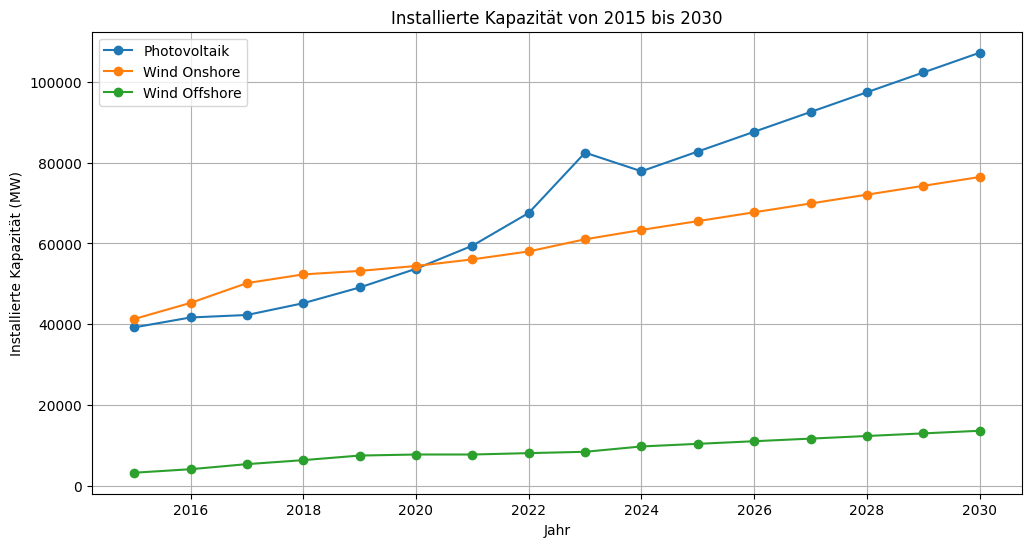

In [131]:
# Kombinieren der historischen und vorhergesagten Daten
historical_years = years.flatten()
historical_pv = installed_capacity_pv
historical_onshore = installed_capacity_onshore
historical_offshore = installed_capacity_offshore

combined_years = np.concatenate((historical_years, future_years.flatten()))
combined_pv = np.concatenate((historical_pv, predicted_pv))
combined_onshore = np.concatenate((historical_onshore, predicted_onshore))
combined_offshore = np.concatenate((historical_offshore, predicted_offshore))

# Plotting the combined data
plt.figure(figsize=(12, 6))

plt.plot(combined_years, combined_pv, label='Photovoltaik', marker='o')
plt.plot(combined_years, combined_onshore, label='Wind Onshore', marker='o')
plt.plot(combined_years, combined_offshore, label='Wind Offshore', marker='o')

plt.xlabel('Jahr')
plt.ylabel('Installierte Kapazität (MW)')
plt.title('Installierte Kapazität von 2015 bis 2030')
plt.legend()
plt.grid(True)
plt.show()